In [1]:
#Import all the modules that are going to be used
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from  datetime import datetime
from sklearn import clone
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score 
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,AdaBoostClassifier)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV



In [2]:
pd.set_option('display.max_columns', 100)
sns.set_style("whitegrid")
sns.set_context("poster")

In [3]:
##################################################################################################
# Airports 
# Get rid of data that contains airports outside of the USA
##################################################################################################
df_airports=pd.read_csv('d:/SpringBoard/US_AirlineData/Supplement/airports.csv',sep=',', delimiter=None, header='infer')
df_airports['iata'] = df_airports['iata'].astype('category') 
df_airports['airport'] = df_airports['airport'].astype('category') 
df_airports['city'] = df_airports['city'].astype('category') 
df_airports['state'] = df_airports['state'].astype('category') 
df_airports['country'] = df_airports['country'].astype('category') 
df_airports=df_airports.drop_duplicates()
df_airports = df_airports[df_airports.country == 'USA']
df_airports.country.value_counts(dropna=True)

USA                               3372
Thailand                             0
Palau                                0
N Mariana Islands                    0
Federated States of Micronesia       0
Name: country, dtype: int64

In [4]:
##################################################################################################
# Carriers  (Airlines) 
##################################################################################################
df_carriers=pd.read_csv('d:/SpringBoard/US_AirlineData/Supplement/carriers.csv',sep=',', delimiter=None, header='infer')
df_carriers=df_carriers.drop_duplicates()
df_carriers.rename(columns={'Description': 'AirlineName'},inplace=True)

In [5]:
##################################################################################################
# Airplane Details
##################################################################################################
df_plane=pd.read_csv('d:/SpringBoard/US_AirlineData/Supplement/plane-data.csv',sep=',', delimiter=None, header='infer')
df_plane = df_plane.dropna(subset=['model'])
df_plane=df_plane.drop_duplicates()
df_plane.rename(columns={'tailnum': 'Tailnum', 'type': 'Type', 'manufacturer': 'Manufacturer','issue_date':'Issuedate'
                         ,'model': 'Model','status':'Status','aircraft_type':'Aircrafttype','engine_type':'Enginetype'
                         ,'year':'YearManufactured'}, inplace=True)
df_plane['Type']             = df_plane['Type'].astype('category') 
df_plane['Status']           = df_plane['Status'].astype('category') 
df_plane['Aircrafttype']     = df_plane['Aircrafttype'].astype('category') 
df_plane['Enginetype']       = df_plane['Enginetype'].astype('category') 
df_plane                     = df_plane.dropna(subset=['YearManufactured'])
df_plane                     = df_plane[df_plane.YearManufactured != 'None']
df_plane['YearManufactured'] = 2008 - df_plane['YearManufactured'].astype('int64') 

In [6]:
# Eliminate all the planes that have a 0000 as Year Manufactured
df_plane = df_plane[df_plane.YearManufactured < 100]

In [7]:
df_plane.YearManufactured.value_counts(dropna=True)

7     389
8     341
9     320
6     306
5     266
10    248
4     240
3     193
17    156
2     152
20    148
16    146
18    145
11    134
21    131
19    110
12    109
1     107
14    103
13    101
15    100
22     92
23     84
0      37
24     27
40     24
25     18
41     16
39     12
29     11
33     10
28      8
32      8
30      8
26      6
31      6
35      3
45      2
49      2
34      2
38      2
44      1
52      1
36      1
37      1
43      1
42      1
46      1
62      1
51      1
Name: YearManufactured, dtype: int64

###### Read the airline arrival/departure data for 2008

In [8]:
##################################################################################################
# Read the airline arrival/departure data for 2008
# (1) Change the object types to Category as this helps cut down memory
# (2) Fill the NaNs with 0 for the Delay column. NaN = 0 = No Delay
# (3) Drop the observations(rows) that have a NaN for Departure/Arrival time - this means that the 
#     data was not recorded properly.
##################################################################################################
df=pd.read_csv('d:/SpringBoard/US_AirlineData/2008.csv',sep=',', delimiter=None, header='infer')
df['UniqueCarrier']     = df['UniqueCarrier'].astype('str')
df['TailNum']           = df['TailNum'].astype('str')              
df['CancellationCode']  = df['CancellationCode'].astype('category') 
df['CarrierDelay']      = df['CarrierDelay'].fillna(0)
df['WeatherDelay']      = df['WeatherDelay'].fillna(0)
df['NASDelay']          = df['NASDelay'].fillna(0)
df['SecurityDelay']     = df['SecurityDelay'].fillna(0)
df['LateAircraftDelay'] = df['LateAircraftDelay'].fillna(0)
df = df.dropna(subset=['DepTime'])
df = df.dropna(subset=['CRSDepTime'])
df = df.dropna(subset=['ArrTime'])
df = df.dropna(subset=['CRSArrTime'])
df = df.drop_duplicates()
df['TotalDelay'] = pd.Series(df['ArrDelay'],index=df.index)
df['TotalDelay'] = df['TotalDelay'].apply(lambda x: x > 0.0)
df['DelayFlag']  = df['TotalDelay'].apply(lambda x: x * 1)

In [9]:
df.DelayFlag.value_counts(dropna=True)

0    3878574
1    2979501
Name: DelayFlag, dtype: int64

In [10]:
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,TotalDelay,DelayFlag
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,0,NaN,0,0.0,0.0,0.0,0.0,0.0,False,0
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,128.0,145.0,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,0,NaN,0,0.0,0.0,0.0,0.0,0.0,True,1
2,2008,1,3,4,628.0,620,804.0,750,WN,448,N428WN,96.0,90.0,76.0,14.0,8.0,IND,BWI,515,3.0,17.0,0,NaN,0,0.0,0.0,0.0,0.0,0.0,True,1
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,N612SW,88.0,90.0,78.0,-6.0,-4.0,IND,BWI,515,3.0,7.0,0,NaN,0,0.0,0.0,0.0,0.0,0.0,False,0
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,N464WN,90.0,90.0,77.0,34.0,34.0,IND,BWI,515,3.0,10.0,0,NaN,0,2.0,0.0,0.0,0.0,32.0,True,1


In [11]:
df = pd.merge(df,df_airports,left_on='Origin',right_on='iata', how='inner')

In [12]:
df.rename(columns={'iata':'OriginIata','airport': 'OriginAirport','city': 'OriginCity','state':'OriginState',
                   'country':'OriginCountry','lat':'OriginLat','long':'OriginLong'}, inplace=True)

In [13]:
df = pd.merge(df,df_airports,left_on='Dest',right_on='iata', how='inner')

In [14]:
df.rename(columns={'iata':'DestIata','airport': 'DestAirport','city': 'DestCity','state':'DestState',
                   'country':'DestCountry','lat':'DestLat','long':'DestLong'}, inplace=True)

In [15]:
df = pd.merge(df,df_carriers,left_on='UniqueCarrier',right_on='Code', how='inner')
del df['Code']
del df['Origin']
del df['Dest']

In [16]:
# A lot of rows get filtered here since the TailNumber in the Plane file does not match the airline arrival/departure file
df = pd.merge(df,df_plane,left_on='TailNum',right_on='Tailnum',suffixes=['_arl', '_plane'], how='inner')
del df['Tailnum']

In [17]:
# Drop all NANs 
df = df.dropna(subset=['AirTime'])       
df = df.dropna(subset=['DayOfWeek'])     
df = df.dropna(subset=['YearManufactured'] )        
df = df.dropna(subset=['Month']   )       
df = df.dropna(subset=['DayofMonth'])      
df = df.dropna(subset=['DayOfWeek'])     
df = df.dropna(subset=['DepTime']  )    
df = df.dropna(subset=['CRSDepTime'] )   
df = df.dropna(subset=['ArrTime'] )       
df = df.dropna(subset=['CRSArrTime'])       
df = df.dropna(subset=['ActualElapsedTime'] )
df = df.dropna(subset=['CRSElapsedTime']    )
df = df.dropna(subset=['AirTime']  )    
df = df.dropna(subset=['ArrDelay'])
df = df.dropna(subset=['DepDelay'])
df = df.dropna(subset=['Distance'] )    
df = df.dropna(subset=['TaxiIn']   )    
df = df.dropna(subset=['TaxiOut']  )    
df = df.dropna(subset=['CarrierDelay'] )    
df = df.dropna(subset=['WeatherDelay'] )    
df = df.dropna(subset=['NASDelay'] )    
df = df.dropna(subset=['SecurityDelay'] )   
df = df.dropna(subset=['LateAircraftDelay'] )
df = df.dropna(subset=['OriginLat']  )
df = df.dropna(subset=['OriginLong'] )
df = df.dropna(subset=['DestLat']    )
df = df.dropna(subset=['DestLong']  ) 
df = df.dropna(subset=['DelayFlag'] )   

In [18]:
# Data Frame with only the observations that have a delay
df_delay= df[df.ArrDelay  > 0.0]

In [19]:
df_delay.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,TotalDelay,DelayFlag,OriginIata,OriginAirport,OriginCity,OriginState,OriginCountry,OriginLat,OriginLong,DestIata,DestAirport,DestCity,DestState,DestCountry,DestLat,DestLong,AirlineName,Type,Manufacturer,Issuedate,Model,Status,Aircrafttype,Enginetype,YearManufactured
1,2008,3,11,2,1649.0,1650,1951.0,1940,WN,3692,N712SW,182.0,170.0,167.0,11.0,-1.0,1034,6.0,9.0,0,NaN,0,0.0,0.0,0.0,0.0,0.0,True,1,ISP,Long Island - MacArthur,Islip,NY,USA,40.795243,-73.100212,TPA,Tampa International,Tampa,FL,USA,27.975472,-82.53325,Southwest Airlines Co.,Corporation,BOEING,07/08/1998,737-7H4,Valid,Fixed Wing Multi-Engine,Turbo-Fan,10
2,2008,7,25,5,1215.0,1050,1510.0,1340,WN,1753,N712SW,175.0,170.0,137.0,90.0,85.0,1034,5.0,33.0,0,NaN,0,0.0,0.0,5.0,73.0,12.0,True,1,ISP,Long Island - MacArthur,Islip,NY,USA,40.795243,-73.100212,TPA,Tampa International,Tampa,FL,USA,27.975472,-82.53325,Southwest Airlines Co.,Corporation,BOEING,07/08/1998,737-7H4,Valid,Fixed Wing Multi-Engine,Turbo-Fan,10
3,2008,4,3,4,1751.0,1750,1844.0,1840,WN,116,N712SW,53.0,50.0,40.0,4.0,1.0,180,3.0,10.0,0,NaN,0,0.0,0.0,0.0,0.0,0.0,True,1,JAX,Jacksonville International,Jacksonville,FL,USA,30.494056,-81.687861,TPA,Tampa International,Tampa,FL,USA,27.975472,-82.53325,Southwest Airlines Co.,Corporation,BOEING,07/08/1998,737-7H4,Valid,Fixed Wing Multi-Engine,Turbo-Fan,10
5,2008,2,29,5,1735.0,1725,38.0,35,WN,3937,N712SW,243.0,250.0,227.0,3.0,10.0,1984,4.0,12.0,0,NaN,0,0.0,0.0,0.0,0.0,0.0,True,1,LAS,McCarran International,Las Vegas,NV,USA,36.080361,-115.152333,TPA,Tampa International,Tampa,FL,USA,27.975472,-82.53325,Southwest Airlines Co.,Corporation,BOEING,07/08/1998,737-7H4,Valid,Fixed Wing Multi-Engine,Turbo-Fan,10
12,2008,10,23,4,1035.0,1035,1407.0,1405,WN,567,N712SW,152.0,150.0,137.0,2.0,0.0,997,3.0,12.0,0,NaN,0,0.0,0.0,0.0,0.0,0.0,True,1,MDW,Chicago Midway,Chicago,IL,USA,41.785983,-87.752424,TPA,Tampa International,Tampa,FL,USA,27.975472,-82.53325,Southwest Airlines Co.,Corporation,BOEING,07/08/1998,737-7H4,Valid,Fixed Wing Multi-Engine,Turbo-Fan,10


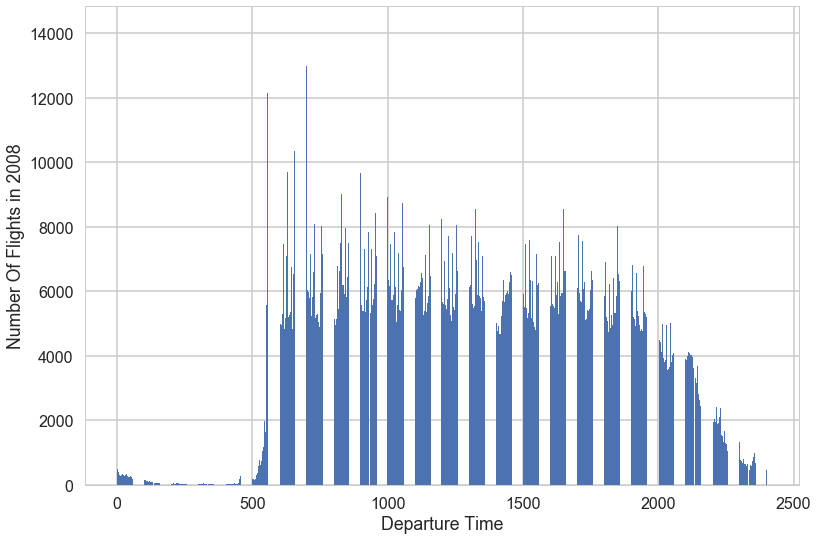

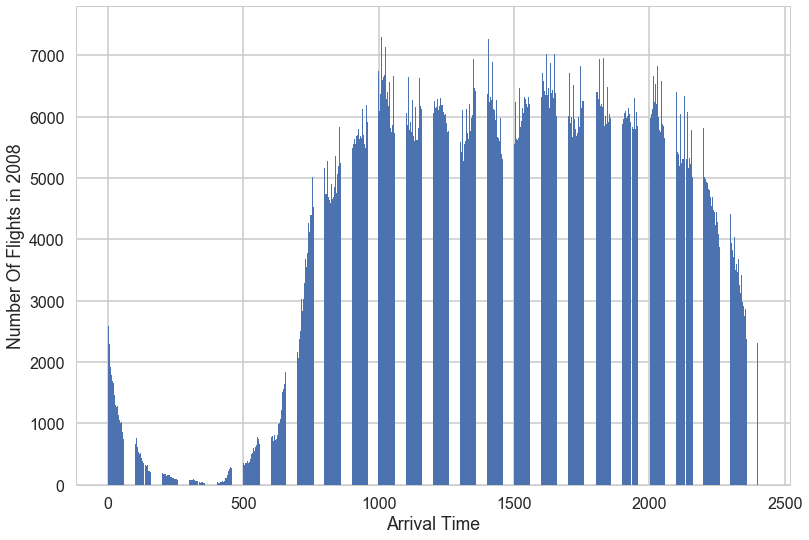

In [20]:
# Compute number of data points: n_data
n_data = len(df)
# Number of bins is the square root of number of data points: n_bins
n_bins = np.sqrt(n_data)
# Convert number of bins to integer: n_bins
n_bins = int(n_bins)


_ = plt.hist(df['DepTime'],n_bins)
_ = plt.xlabel('Departure Time')
_ = plt.ylabel('Number Of Flights in 2008')
_ = plt.show()

_ = plt.hist(df['ArrTime'],n_bins)
_ = plt.xlabel('Arrival Time')
_ = plt.ylabel('Number Of Flights in 2008')
_ = plt.show()

In [21]:
delay_percent = (len(df_delay) / len(df)) * 100.00
print(delay_percent)

43.56115858348878


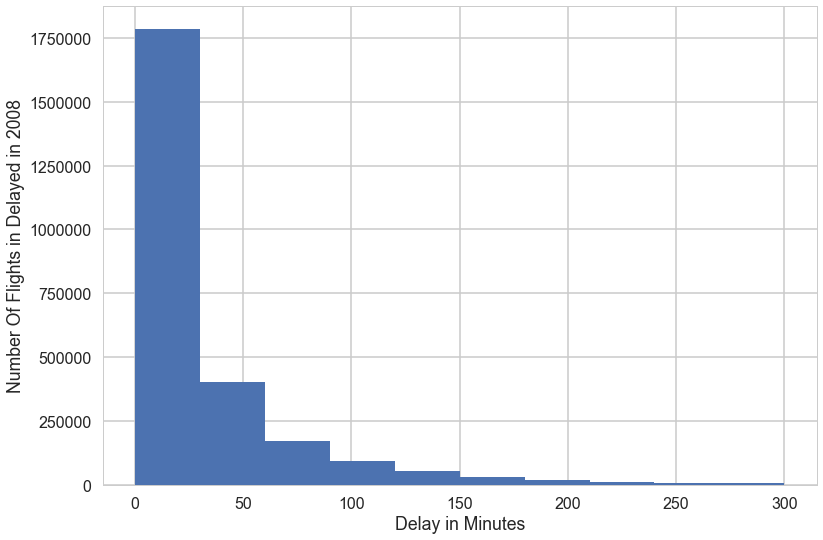

In [22]:
bin_edges = [0, 30, 60, 90,120,150,180,210,240,270,300]
_ = plt.hist(df_delay['ArrDelay'], bins=bin_edges)
_ = plt.xlabel('Delay in Minutes')
_ = plt.ylabel('Number Of Flights in Delayed in 2008')
_ = plt.show()

In [23]:
df_delay.head(10)

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,TotalDelay,DelayFlag,OriginIata,OriginAirport,OriginCity,OriginState,OriginCountry,OriginLat,OriginLong,DestIata,DestAirport,DestCity,DestState,DestCountry,DestLat,DestLong,AirlineName,Type,Manufacturer,Issuedate,Model,Status,Aircrafttype,Enginetype,YearManufactured
1,2008,3,11,2,1649.0,1650,1951.0,1940,WN,3692,N712SW,182.0,170.0,167.0,11.0,-1.0,1034,6.0,9.0,0,NaN,0,0.0,0.0,0.0,0.0,0.0,True,1,ISP,Long Island - MacArthur,Islip,NY,USA,40.795243,-73.100212,TPA,Tampa International,Tampa,FL,USA,27.975472,-82.53325,Southwest Airlines Co.,Corporation,BOEING,07/08/1998,737-7H4,Valid,Fixed Wing Multi-Engine,Turbo-Fan,10
2,2008,7,25,5,1215.0,1050,1510.0,1340,WN,1753,N712SW,175.0,170.0,137.0,90.0,85.0,1034,5.0,33.0,0,NaN,0,0.0,0.0,5.0,73.0,12.0,True,1,ISP,Long Island - MacArthur,Islip,NY,USA,40.795243,-73.100212,TPA,Tampa International,Tampa,FL,USA,27.975472,-82.53325,Southwest Airlines Co.,Corporation,BOEING,07/08/1998,737-7H4,Valid,Fixed Wing Multi-Engine,Turbo-Fan,10
3,2008,4,3,4,1751.0,1750,1844.0,1840,WN,116,N712SW,53.0,50.0,40.0,4.0,1.0,180,3.0,10.0,0,NaN,0,0.0,0.0,0.0,0.0,0.0,True,1,JAX,Jacksonville International,Jacksonville,FL,USA,30.494056,-81.687861,TPA,Tampa International,Tampa,FL,USA,27.975472,-82.53325,Southwest Airlines Co.,Corporation,BOEING,07/08/1998,737-7H4,Valid,Fixed Wing Multi-Engine,Turbo-Fan,10
5,2008,2,29,5,1735.0,1725,38.0,35,WN,3937,N712SW,243.0,250.0,227.0,3.0,10.0,1984,4.0,12.0,0,NaN,0,0.0,0.0,0.0,0.0,0.0,True,1,LAS,McCarran International,Las Vegas,NV,USA,36.080361,-115.152333,TPA,Tampa International,Tampa,FL,USA,27.975472,-82.53325,Southwest Airlines Co.,Corporation,BOEING,07/08/1998,737-7H4,Valid,Fixed Wing Multi-Engine,Turbo-Fan,10
12,2008,10,23,4,1035.0,1035,1407.0,1405,WN,567,N712SW,152.0,150.0,137.0,2.0,0.0,997,3.0,12.0,0,NaN,0,0.0,0.0,0.0,0.0,0.0,True,1,MDW,Chicago Midway,Chicago,IL,USA,41.785983,-87.752424,TPA,Tampa International,Tampa,FL,USA,27.975472,-82.53325,Southwest Airlines Co.,Corporation,BOEING,07/08/1998,737-7H4,Valid,Fixed Wing Multi-Engine,Turbo-Fan,10
16,2008,1,19,6,1203.0,1135,1422.0,1400,WN,2803,N712SW,79.0,85.0,64.0,22.0,28.0,487,4.0,11.0,0,NaN,0,0.0,0.0,0.0,0.0,22.0,True,1,MSY,New Orleans International,New Orleans,LA,USA,29.993389,-90.258028,TPA,Tampa International,Tampa,FL,USA,27.975472,-82.53325,Southwest Airlines Co.,Corporation,BOEING,07/08/1998,737-7H4,Valid,Fixed Wing Multi-Engine,Turbo-Fan,10
19,2008,2,5,2,2123.0,1930,17.0,2225,WN,811,N712SW,174.0,175.0,138.0,112.0,113.0,920,3.0,33.0,0,NaN,0,0.0,0.0,0.0,0.0,112.0,True,1,PHL,Philadelphia Intl,Philadelphia,PA,USA,39.871953,-75.241141,TPA,Tampa International,Tampa,FL,USA,27.975472,-82.53325,Southwest Airlines Co.,Corporation,BOEING,07/08/1998,737-7H4,Valid,Fixed Wing Multi-Engine,Turbo-Fan,10
21,2008,8,27,3,931.0,920,1629.0,1620,WN,240,N712SW,238.0,240.0,221.0,9.0,11.0,1788,4.0,13.0,0,NaN,0,0.0,0.0,0.0,0.0,0.0,True,1,PHX,Phoenix Sky Harbor International,Phoenix,AZ,USA,33.434167,-112.008056,TPA,Tampa International,Tampa,FL,USA,27.975472,-82.53325,Southwest Airlines Co.,Corporation,BOEING,07/08/1998,737-7H4,Valid,Fixed Wing Multi-Engine,Turbo-Fan,10
22,2008,3,6,4,642.0,645,1002.0,1000,WN,1336,N712SW,200.0,195.0,181.0,2.0,-3.0,1137,4.0,15.0,0,NaN,0,0.0,0.0,0.0,0.0,0.0,True,1,PVD,Theodore F Green State,Providence,RI,USA,41.723999,-71.428221,TPA,Tampa International,Tampa,FL,USA,27.975472,-82.53325,Southwest Airlines Co.,Corporation,BOEING,07/08/1998,737-7H4,Valid,Fixed Wing Multi-Engine,Turbo-Fan,10
23,2008,3,25,2,1938.0,1935,2245.0,2240,WN,1341,N712SW,187.0,185.0,166.0,5.0,3.0,1137,12.0,9.0,0,NaN,0,0.0,0.0,0.0,0.0,0.0,True,1,PVD,Theodore F Green State,Providence,RI,USA,41.723999,-71.428221,TPA,Tampa International,Tampa,FL,USA,27.975472,-82.53325,South

In [24]:
df_delay.DestState.value_counts(dropna=True)

CA    314611
TX    256208
GA    180929
FL    172487
IL    166688
NY    132864
CO    112199
AZ     85543
NV     78576
NC     77819
VA     73968
NJ     64962
PA     57419
MI     55848
WA     53591
UT     50971
MO     49656
OH     47658
MN     44559
KY     44404
TN     43585
MA     41867
MD     38641
HI     36428
OR     30727
WI     28029
LA     23652
IN     19459
OK     18734
AK     17569
NM     16606
AL     15468
SC     15041
NE     11984
AR     11744
CT     10663
ID     10203
IA      8674
RI      8648
MS      8059
MT      7430
NH      7372
PR      6763
KS      5100
ME      3624
WY      3534
SD      3499
ND      2950
VT      2433
WV      1281
VI       995
DC         0
DE         0
CQ         0
AS         0
GU         0
Name: DestState, dtype: int64

In [25]:
df_delay.DestIata.value_counts(dropna=True)

ATL    172263
ORD    127137
DEN     97959
LAX     79451
DFW     74682
PHX     74061
IAH     72791
LAS     68620
EWR     64904
SFO     61324
MCO     49920
SLC     49720
LGA     49474
JFK     48095
CLT     46782
SEA     45273
MSP     43077
DTW     41794
BOS     41617
BWI     38641
PHL     36940
SAN     35952
CVG     32837
MDW     31766
TPA     30162
IAD     28136
FLL     28079
DCA     27418
CLE     25435
MCI     24464
        ...  
M36         0
M34         0
M33         0
M32         0
M30         0
M72         0
M73         0
M75         0
MAC         0
MBO         0
MBL         0
MBG         0
MAZ         0
MAW         0
MAO         0
MAL         0
MAI         0
MAE         0
M99         0
M76         0
M97         0
M95         0
M91         0
M89         0
M83         0
M82         0
M79         0
M78         0
M77         0
00M         0
Name: DestIata, Length: 3376, dtype: int64

In [26]:
df_delay.Enginetype.value_counts(dropna=True)

Turbo-Fan        1764070
Turbo-Jet         730347
Turbo-Prop         72284
Reciprocating      12955
4 Cycle             1387
None                 998
Turbo-Shaft          880
Name: Enginetype, dtype: int64

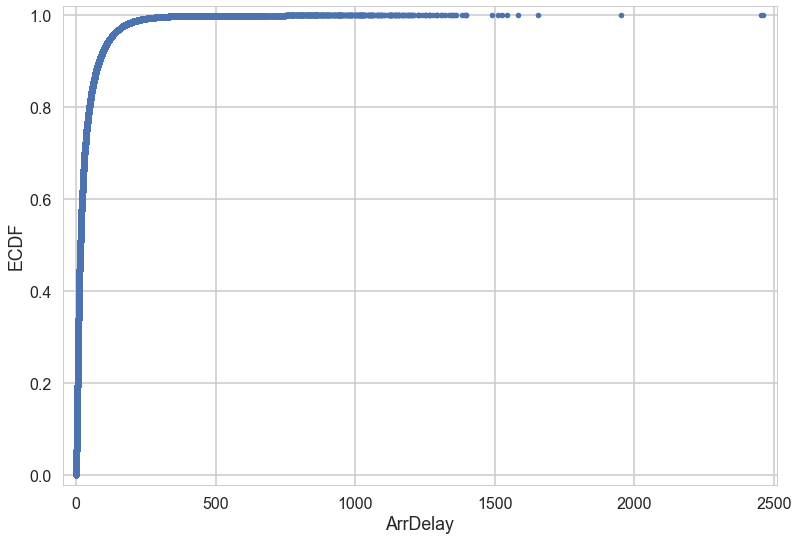

In [27]:
x = np.sort(df_delay['ArrDelay'])
y = np.arange(1,len(x)+1)/len(x)
_ = plt.plot(x,y,marker='.',linestyle='none')
_ = plt.xlabel('ArrDelay')
_ = plt.ylabel('ECDF')
plt.margins(0.02)
plt.show()

In [29]:
df_delay_iata = df_delay.set_index(['DestIata'])

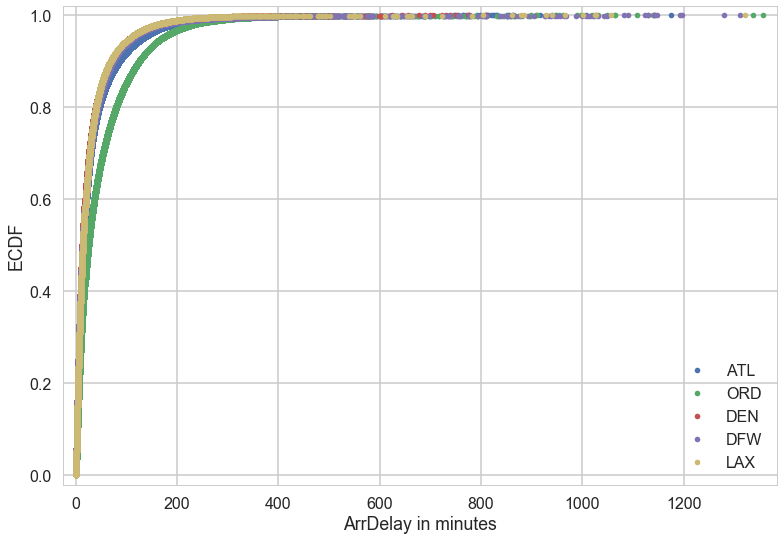

In [31]:

df_delay_iata = df_delay_iata.loc[['ATL','ORD','DEN','DFW','LAX'], :]
 

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    return x, y

d_ATL = df_delay_iata['ArrDelay']['ATL']
d_ORD = df_delay_iata['ArrDelay']['ORD']
d_DEN = df_delay_iata['ArrDelay']['DEN']
d_DFW = df_delay_iata['ArrDelay']['DFW']
d_LAX = df_delay_iata['ArrDelay']['LAX']

# Compute ECDFs
x_ATL, y_ATL = ecdf(d_ATL)
x_ORD, y_ORD = ecdf(d_ORD)
x_DEN, y_DEN = ecdf(d_DEN)
x_DFW, y_DFW = ecdf(d_DFW)
x_LAX, y_LAX = ecdf(d_LAX)

                                     

# Plot all ECDFs on the same plot
_ = plt.plot(x_ATL, y_ATL, marker='.', linestyle='none')
_ = plt.plot(x_ORD, y_ORD, marker='.', linestyle='none')
_ = plt.plot(x_DEN, y_DEN, marker='.', linestyle='none')
_ = plt.plot(x_DFW, y_DFW, marker='.', linestyle='none')
_ = plt.plot(x_LAX, y_LAX, marker='.', linestyle='none')
                                     
#_ = plt.plot(x_virg, y_virg, marker='.', linestyle='none')

# Make nice margins
plt.margins(0.02)

# Annotate the plot
_ = plt.legend(('ATL','ORD','DEN','DFW','LAX'), loc='lower right')
_ = plt.xlabel('ArrDelay in minutes')
_ = plt.ylabel('ECDF')

# Display the plot
plt.show()


In [32]:
df_delay.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2582921 entries, 1 to 5931825
Data columns (total 52 columns):
Year                 int64
Month                int64
DayofMonth           int64
DayOfWeek            int64
DepTime              float64
CRSDepTime           int64
ArrTime              float64
CRSArrTime           int64
UniqueCarrier        object
FlightNum            int64
TailNum              object
ActualElapsedTime    float64
CRSElapsedTime       float64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Distance             int64
TaxiIn               float64
TaxiOut              float64
Cancelled            int64
CancellationCode     category
Diverted             int64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
TotalDelay           bool
DelayFlag            int64
OriginIata           category
OriginAirport        category
OriginCity  

## Create a slice for the 3 regional airports of interest - JFK, LGA, EWR 

In [33]:
## Slice by the 3 airports of interest to us 
df_delay_NYNJ = df_delay.set_index(['DestIata'])
df_delay_NYNJ= df_delay_NYNJ.loc[['JFK','LGA','EWR'], :]


In [34]:
df_delay_NYNJ.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 162473 entries, JFK to EWR
Data columns (total 51 columns):
Year                 162473 non-null int64
Month                162473 non-null int64
DayofMonth           162473 non-null int64
DayOfWeek            162473 non-null int64
DepTime              162473 non-null float64
CRSDepTime           162473 non-null int64
ArrTime              162473 non-null float64
CRSArrTime           162473 non-null int64
UniqueCarrier        162473 non-null object
FlightNum            162473 non-null int64
TailNum              162473 non-null object
ActualElapsedTime    162473 non-null float64
CRSElapsedTime       162473 non-null float64
AirTime              162473 non-null float64
ArrDelay             162473 non-null float64
DepDelay             162473 non-null float64
Distance             162473 non-null int64
TaxiIn               162473 non-null float64
TaxiOut              162473 non-null float64
Cancelled            162473 non-null int64
Canc

In [35]:
df_delay_NYNJ.DestAirport.value_counts(dropna=True)

Newark Intl                                 64904
LaGuardia                                   49474
John F Kennedy Intl                         48095
Gen Edw L Logan Intl                            0
Geauga County                                   0
Gatlinburg-Pigeon Forge                         0
Gatesville - City/County                        0
Gastonia Municipal                              0
Gary/Chicago                                    0
Garrison Municipal                              0
Garrett County                                  0
Garnett Municipal                               0
Garner                                          0
Zephyrhills Municipal                           0
Garland Heliport                                0
Garfield County Regional                        0
Gardner Municipal                               0
Gardiner                                        0
Garden County                                   0
Garden City Regional                            0


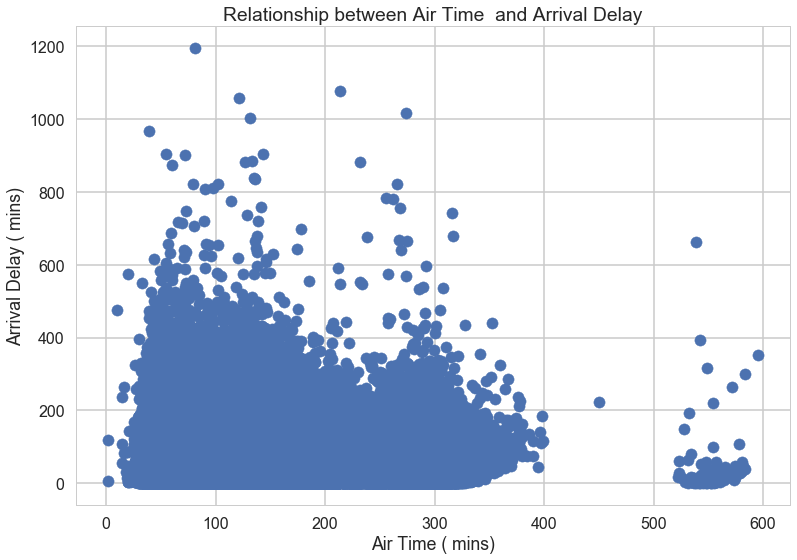

In [36]:
# Correlation between airtime and delay. Do longer flights and delays go together
plt.scatter(df_delay_NYNJ.AirTime, df_delay_NYNJ.ArrDelay)
plt.xlabel("Air Time ( mins)")
plt.ylabel("Arrival Delay ( mins)")
plt.title("Relationship between Air Time  and Arrival Delay")
plt.show()

## There seems to be a negative correlation between Arrival Delay and Air Time after a certain threshold ( a sharp peak and then a fat tail)

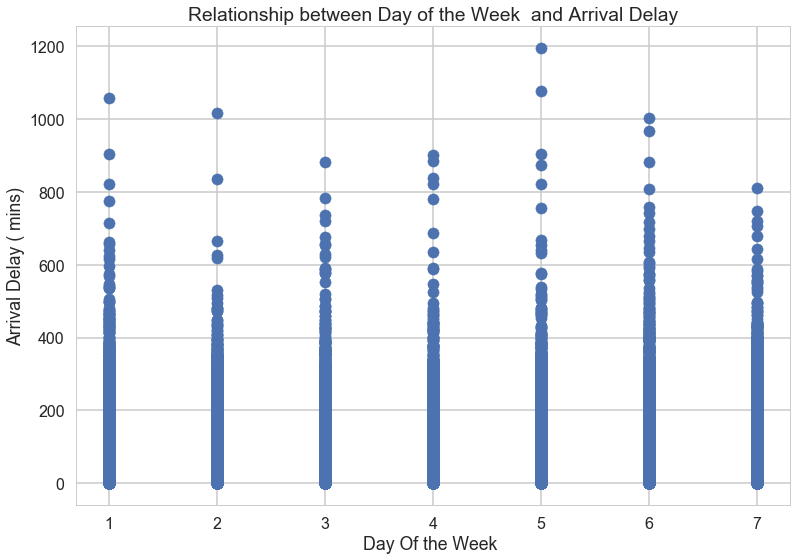

In [37]:
# Correlation between day of the week  and delay. 
plt.scatter(df_delay_NYNJ.DayOfWeek, df_delay_NYNJ.ArrDelay)
plt.xlabel("Day Of the Week ")
plt.ylabel("Arrival Delay ( mins)")
plt.title("Relationship between Day of the Week  and Arrival Delay")
plt.show()


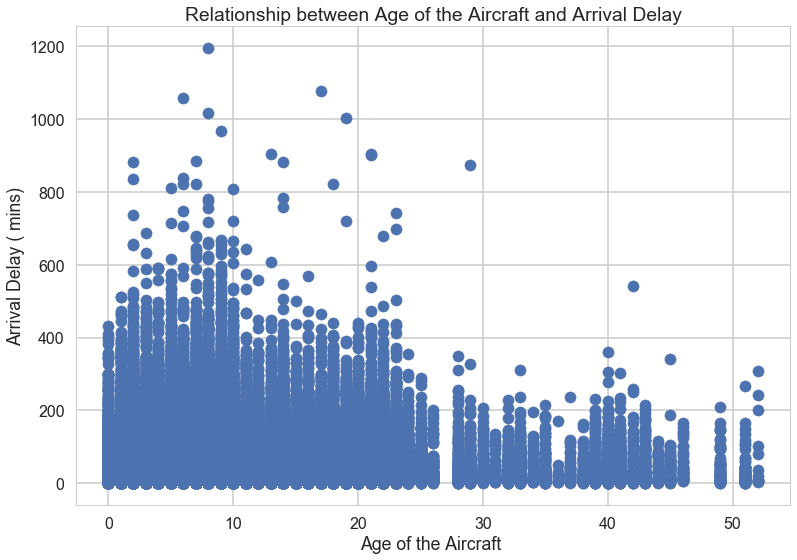

In [38]:
# Correlation between Age and delay.
plt.scatter(df_delay_NYNJ.YearManufactured, df_delay_NYNJ.ArrDelay)
plt.xlabel("Age of the Aircraft ")
plt.ylabel("Arrival Delay ( mins)")
plt.title("Relationship between Age of the Aircraft and Arrival Delay")
plt.show()

## There does not seem to be any correlation between Total Delay and Age of the aircraft

Run different classifiers - LinearRegression, LogisticRegression, DecisionTrees and KMeans clustering on the dataset

#### Let us try Linear Regression with 3 features  and check prediction of delays

In [39]:
df_3 = pd.DataFrame({'AirTime': df_delay_NYNJ.AirTime, 'DayOfWeek': df_delay_NYNJ.DayOfWeek,'Age' : df_delay_NYNJ.YearManufactured})[['AirTime', 'DayOfWeek','Age']] 
X_train, X_test, y_train, y_test = train_test_split(df_3, df_delay_NYNJ.ArrDelay,test_size = 0.3, random_state=42) 

reg_all = LinearRegression() 
reg_all.fit(X_train, y_train) 
y_pred = reg_all.predict(X_test) 
reg_all.score(X_test, y_test) 

0.0044376864188763188

#### The RSquared score is too low . Might be because of the way in which the data was split to get the 70/30.

#### Implementing k-fold cross validation below, with folds of 10,100 and 1000 since there are 2.5 million observations.

reg_cv = LinearRegression() 
cv_results = cross_val_score(reg_cv, df_3, df_delay.ArrDelay, cv=10) 

np.mean(cv_results) 

cv_results = cross_val_score(reg_cv, df_3, df_delay.ArrDelay, cv=100) 

np.mean(cv_results) 

cv_results = cross_val_score(reg_cv, df_3, df_delay.ArrDelay, cv=1000) 

np.mean(cv_results) 

#### The mean values of the cv_results increases but does not seem to be too useful for prediction. Will have to use more features from the df_delay data frame

In [40]:
df_N = pd.DataFrame({'AirTime'           : df_delay_NYNJ.AirTime
                    ,'Age'               : df_delay_NYNJ.YearManufactured
                    ,'Month'             : df_delay_NYNJ.Month
                    ,'DayofMonth'        : df_delay_NYNJ.DayofMonth         
                    ,'DayOfWeek'         : df_delay_NYNJ.DayOfWeek
                    ,'DepTime'           : df_delay_NYNJ.DepTime
                    ,'CRSDepTime'        : df_delay_NYNJ.CRSDepTime
                    ,'ArrTime'           : df_delay_NYNJ.ArrTime
                    ,'CRSArrTime'        : df_delay_NYNJ.CRSArrTime
                    ,'ActualElapsedTime' : df_delay_NYNJ.ActualElapsedTime
                    ,'CRSElapsedTime'    : df_delay_NYNJ.CRSElapsedTime
                    ,'AirTime'           : df_delay_NYNJ.AirTime
                    ,'Distance'          : df_delay_NYNJ.Distance
                    ,'TaxiIn'            : df_delay_NYNJ.TaxiIn
                    ,'TaxiOut'           : df_delay_NYNJ.TaxiOut
                    ,'CarrierDelay'      : df_delay_NYNJ.CarrierDelay
                    ,'WeatherDelay'      : df_delay_NYNJ.WeatherDelay
                    ,'NASDelay'          : df_delay_NYNJ.NASDelay
                    ,'SecurityDelay'     : df_delay_NYNJ.SecurityDelay
                    ,'LateAircraftDelay' : df_delay_NYNJ.LateAircraftDelay
                    ,'OriginLat'         : df_delay_NYNJ.OriginLat
                    ,'OriginLong'        : df_delay_NYNJ.OriginLong
                    ,'DestLat'           : df_delay_NYNJ.DestLat
                    ,'DestLong'          : df_delay_NYNJ.DestLong
                    })[['AirTime'
                        ,'Age'
                        ,'Month'                
                        ,'DayofMonth'           
                        ,'DayOfWeek'            
                        ,'DepTime'              
                        ,'CRSDepTime'           
                        ,'ArrTime'              
                        ,'CRSArrTime'           
                        ,'ActualElapsedTime'    
                        ,'CRSElapsedTime'       
                        ,'AirTime'              
                        ,'Distance'             
                        ,'TaxiIn'               
                        ,'TaxiOut'  
                        ,'CarrierDelay'         
                        ,'WeatherDelay'         
                        ,'NASDelay'             
                        ,'SecurityDelay'        
                        ,'LateAircraftDelay'    
                        ,'OriginLat'            
                        ,'OriginLong'           
                        ,'DestLat'              
                        ,'DestLong']] 

In [41]:
reg_cv = LinearRegression() 
cv_results = cross_val_score(reg_cv, df_N, df_delay_NYNJ.ArrDelay, cv=10) 
np.mean(cv_results) 

0.99592508970891203

##### This is a really high RSquared value. It might be due to the fact that RSquared gets inflated as the number of features increases

In [42]:
X=df_N
y=df_delay_NYNJ.ArrDelay
reg_cv = LinearRegression() 
y_predicted = cross_val_predict(reg_cv, X, y, cv=10)

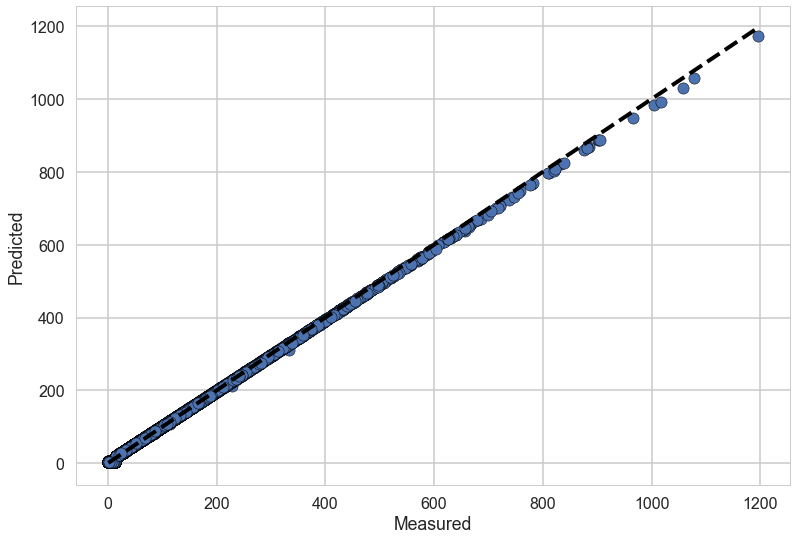

In [43]:

fig, ax = plt.subplots()
ax.scatter(y, y_predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

##### This shows that the model predictions are very close to the Actual values !

In [44]:
#Lasso regression - 
X=df_N
y=df_delay_NYNJ.ArrDelay
names = df_N.columns
lasso = Lasso(alpha=1, max_iter=10000)
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X,y,test_size = 0.3, random_state=42) 

lasso_coef = lasso.fit(X_train_l,y_train_l).coef_
y_pred_l = lasso.predict(X_test_l)


In [45]:
lasso.score(X_test_l,y_test_l)

0.99614285384265033

In [46]:
lasso_coef

array([ -0.00000000e+00,  -0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   1.94146901e-04,
        -4.85786614e-04,  -4.00573433e-04,  -1.27506254e-05,
        -2.24201009e-03,  -0.00000000e+00,  -0.00000000e+00,
         3.21674001e-04,   0.00000000e+00,  -1.47725098e-03,
         9.76562657e-01,   9.69469767e-01,   9.69732558e-01,
         2.67983878e-01,   9.69844732e-01,  -0.00000000e+00,
         0.00000000e+00,  -0.00000000e+00,   0.00000000e+00])

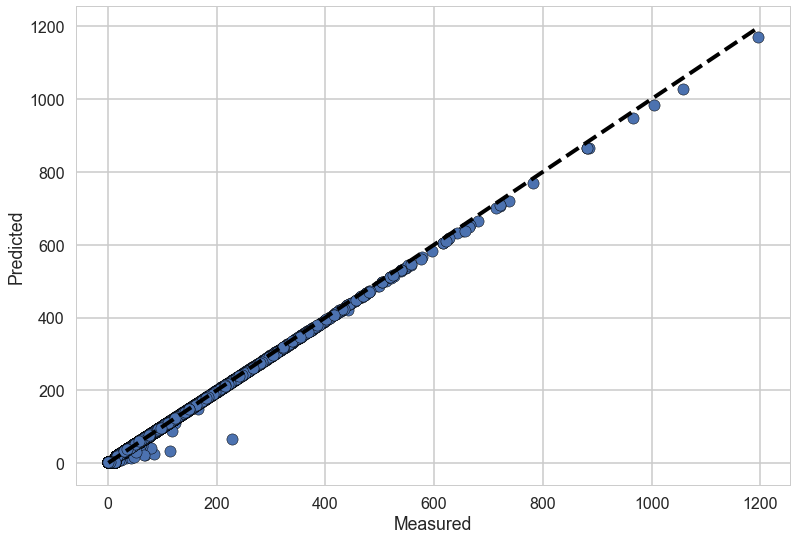

In [47]:
y=y_test_l
fig, ax = plt.subplots()
ax.scatter(y, y_pred_l, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

##### Let us figure out the significant features by plotting the coefficients

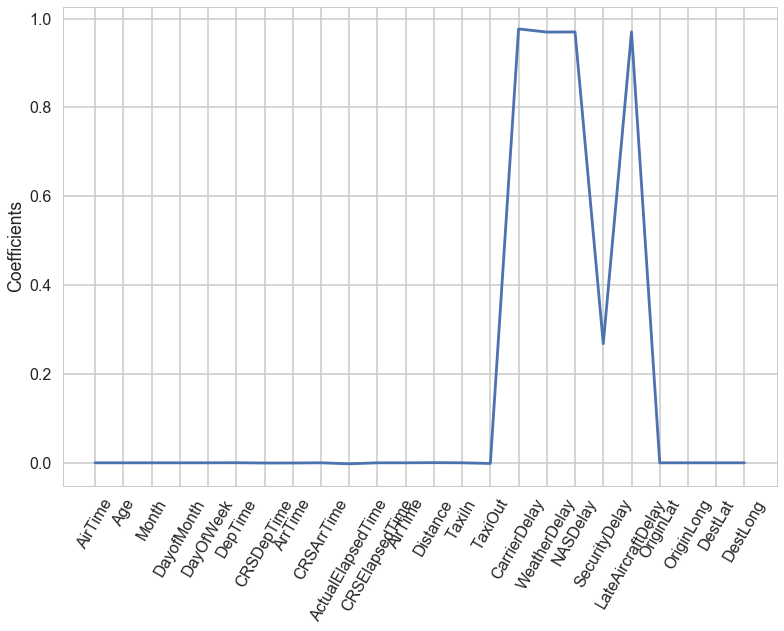

In [48]:
_ = plt.plot(range(len(names)), lasso_coef)
_ = plt.xticks(range(len(names)), names, rotation=60)
_ = plt.ylabel('Coefficients')
plt.show()

##### From Lasso Regression we see that the significant features are - Carrier Delay, WeatherDelay, NASDelay, SecurityDelay and LateAircraftDelay.

##### Next  we want to run some Decision Trees and Random forest classifier with the DelayFlag ( 1= Delay, 0= No delay) as the categorical target variable. Using the entire dataset of 5+ million rows which includes both delayed and non-delayed flights.

In [49]:
df_NYNJ = df.set_index(['DestIata'])
df_NYNJ = df_NYNJ.loc[['JFK','LGA','EWR'], :]

In [50]:
df_NYNJ.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 323811 entries, JFK to EWR
Data columns (total 51 columns):
Year                 323811 non-null int64
Month                323811 non-null int64
DayofMonth           323811 non-null int64
DayOfWeek            323811 non-null int64
DepTime              323811 non-null float64
CRSDepTime           323811 non-null int64
ArrTime              323811 non-null float64
CRSArrTime           323811 non-null int64
UniqueCarrier        323811 non-null object
FlightNum            323811 non-null int64
TailNum              323811 non-null object
ActualElapsedTime    323811 non-null float64
CRSElapsedTime       323811 non-null float64
AirTime              323811 non-null float64
ArrDelay             323811 non-null float64
DepDelay             323811 non-null float64
Distance             323811 non-null int64
TaxiIn               323811 non-null float64
TaxiOut              323811 non-null float64
Cancelled            323811 non-null int64
Canc

In [51]:
df_RF = pd.DataFrame({'AirTime'          : df_NYNJ.AirTime
                    ,'Age'               : df_NYNJ.YearManufactured
                    ,'Month'             : df_NYNJ.Month
                    ,'DayofMonth'        : df_NYNJ.DayofMonth         
                    ,'DayOfWeek'         : df_NYNJ.DayOfWeek
                    ,'DepTime'           : df_NYNJ.DepTime
                    ,'CRSDepTime'        : df_NYNJ.CRSDepTime
                    ,'ArrTime'           : df_NYNJ.ArrTime
                    ,'CRSArrTime'        : df_NYNJ.CRSArrTime
                    ,'ActualElapsedTime' : df_NYNJ.ActualElapsedTime
                    ,'CRSElapsedTime'    : df_NYNJ.CRSElapsedTime
                    ,'AirTime'           : df_NYNJ.AirTime
                    ,'Distance'          : df_NYNJ.Distance
                    ,'TaxiIn'            : df_NYNJ.TaxiIn
                    ,'TaxiOut'           : df_NYNJ.TaxiOut
                    ,'CarrierDelay'      : df_NYNJ.CarrierDelay
                    ,'WeatherDelay'      : df_NYNJ.WeatherDelay
                    ,'NASDelay'          : df_NYNJ.NASDelay
                    ,'SecurityDelay'     : df_NYNJ.SecurityDelay
                    ,'LateAircraftDelay' : df_NYNJ.LateAircraftDelay
                    ,'OriginLat'         : df_NYNJ.OriginLat
                    ,'OriginLong'        : df_NYNJ.OriginLong
                    ,'DestLat'           : df_NYNJ.DestLat
                    ,'DestLong'          : df_NYNJ.DestLong
                    })[['AirTime'
                        ,'Age'
                        ,'Month'                
                        ,'DayofMonth'           
                        ,'DayOfWeek'            
                        ,'DepTime'              
                        ,'CRSDepTime'           
                        ,'ArrTime'              
                        ,'CRSArrTime'           
                        ,'ActualElapsedTime'    
                        ,'CRSElapsedTime'       
                        ,'AirTime'              
                        ,'Distance'             
                        ,'TaxiIn'               
                        ,'TaxiOut'    
                        ,'CarrierDelay'         
                        ,'WeatherDelay'         
                        ,'NASDelay'             
                        ,'SecurityDelay'        
                        ,'LateAircraftDelay'    
                        ,'OriginLat'            
                        ,'OriginLong'           
                        ,'DestLat'              
                        ,'DestLong']] 

In [52]:
X=df_RF
y=df_NYNJ.DelayFlag

In [53]:
X.head()

,AirTime,Age,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,OriginLat,OriginLong,DestLat,DestLong
DestIata,,,,,,,,,,,,,,,,,,,,,,,,
JFK,299.0,17,1,21,1,553.0,600,1437.0,1424,344.0,324.0,299.0,2586,5.0,40.0,0.0,0.0,0.0,0.0,0.0,37.619002,-122.374843,40.639751,-73.778926
JFK,286.0,17,1,20,7,1052.0,1035,1907.0,1902,315.0,327.0,286.0,2586,3.0,26.0,0.0,0.0,0.0,0.0,0.0,37.619002,-122.374843,40.639751,-73.778926
JFK,318.0,15,6,25,3,2327.0,2330,803.0,753,336.0,323.0,318.0,2475,5.0,13.0,0.0,0.0,0.0,0.0,0.0,33.942536,-118.408074,40.639751,-73.778926
JFK,310.0,15,6,26,4,1405.0,1405,2239.0,2248,334.0,343.0,310.0,2475,10.0,14.0,0.0,0.0,0.0,0.0,0.0,33.942536,-118.408074,40.639751,-73.778926
JFK,260.0,15,12,16,2,725.0,727,1518.0,1600,293.0,333.0,260.0,2586,3.0,30.0,0.0,0.0,0.0,0.0,0.0,37.619002,-122.374843,40.639751,-73.778926


In [54]:
y.head()

DestIata
JFK    1
JFK    1
JFK    1
JFK    0
JFK    0
Name: DelayFlag, dtype: int64

In [55]:
clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2,random_state=0)

In [56]:
scores = cross_val_score(clf, X, y)
scores.mean()    

0.72726678719096272

In [57]:
y_predicted = cross_val_predict(clf, X, y, cv=5)
accuracy_score(y, y_predicted) 

0.84074969658226562

In [58]:
clf = RandomForestClassifier(n_estimators=10, max_depth=None,min_samples_split=2, random_state=0)
scores = cross_val_score(clf, X, y)
scores.mean()   

0.74548115614883093

In [59]:
y_predicted = cross_val_predict(clf, X, y, cv=5)
accuracy_score(y, y_predicted) 

0.86803721924208876

In [60]:
clf = ExtraTreesClassifier(n_estimators=10, max_depth=None,min_samples_split=2, random_state=0)
scores = cross_val_score(clf, X, y)
scores.mean()

0.66565090858579867

In [61]:
y_predicted = cross_val_predict(clf, X, y, cv=5)
accuracy_score(y, y_predicted) 

0.8472133435862278

Feature ranking:
1. feature 17 (0.274724)
2. feature 14 (0.085275)
3. feature 9 (0.073849)
4. feature 19 (0.066754)
5. feature 7 (0.060734)
6. feature 10 (0.053681)
7. feature 15 (0.051187)
8. feature 8 (0.044574)
9. feature 5 (0.039497)
10. feature 11 (0.032027)
11. feature 0 (0.029062)
12. feature 6 (0.028421)
13. feature 13 (0.026968)
14. feature 3 (0.021466)
15. feature 12 (0.019491)
16. feature 1 (0.019384)
17. feature 2 (0.017381)
18. feature 4 (0.013319)
19. feature 21 (0.012164)
20. feature 20 (0.011438)
21. feature 16 (0.010009)
22. feature 22 (0.004580)
23. feature 23 (0.003881)
24. feature 18 (0.000135)


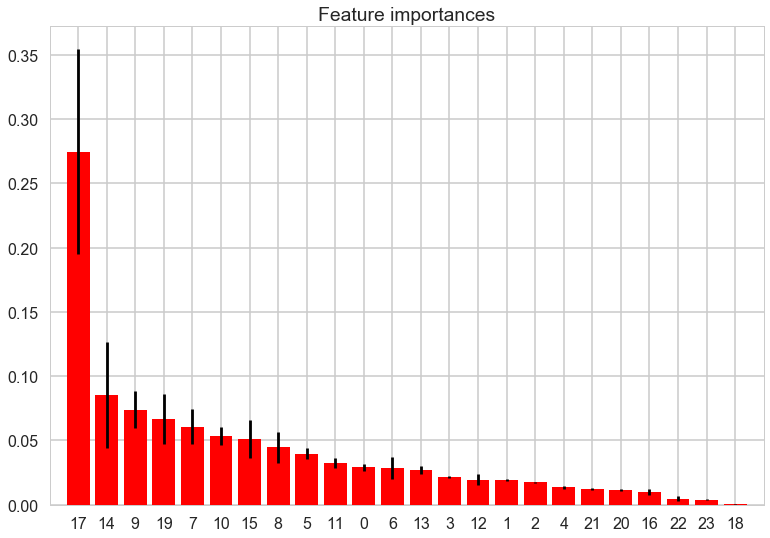

In [62]:
# Build a forest and compute the feature importances

forest = RandomForestClassifier(n_estimators=10, max_depth=None,min_samples_split=2, random_state=0)


forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

Feature ranking:
1. feature 17 (0.130942)
2. feature 14 (0.101160)
3. feature 7 (0.095659)
4. feature 9 (0.080016)
5. feature 5 (0.066367)
6. feature 8 (0.056601)
7. feature 19 (0.053855)
8. feature 10 (0.043687)
9. feature 0 (0.041010)
10. feature 6 (0.040414)
11. feature 11 (0.038437)
12. feature 13 (0.036530)
13. feature 15 (0.034459)
14. feature 2 (0.026362)
15. feature 12 (0.024178)
16. feature 3 (0.023722)
17. feature 1 (0.023419)
18. feature 4 (0.022805)
19. feature 21 (0.019844)
20. feature 20 (0.018628)
21. feature 16 (0.007649)
22. feature 22 (0.007525)
23. feature 23 (0.006493)
24. feature 18 (0.000238)


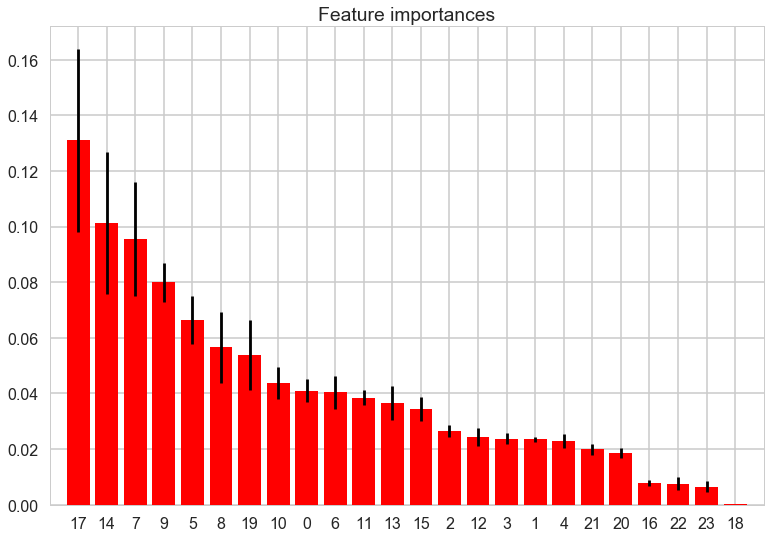

In [63]:
# Build a forest and compute the feature importances

forest = ExtraTreesClassifier(n_estimators=10, max_depth=None,min_samples_split=2, random_state=0)


forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [64]:
# Try Logistic Regression 
# Try out KMeans Clustering 

In [65]:
df_delay_Origin_NYNJ = df.set_index(['OriginIata'])
df_delay_Origin_NYNJ = df_delay_Origin_NYNJ.loc[['JFK','LGA','EWR'], :]

In [66]:
df_Origin_NYNJ_RF = pd.DataFrame({'Month'            : df_delay_Origin_NYNJ.Month
                                ,'DayofMonth'        : df_delay_Origin_NYNJ.DayofMonth         
                                ,'DayOfWeek'         : df_delay_Origin_NYNJ.DayOfWeek
                                ,'DepTime'           : df_delay_Origin_NYNJ.DepTime
                                })[['Month'                
                                    ,'DayofMonth'           
                                    ,'DayOfWeek'            
                                    ,'DepTime'  ]] 

In [67]:
X=df_Origin_NYNJ_RF
y=df_delay_Origin_NYNJ.DelayFlag

In [68]:
logreg = LogisticRegression()
y_predicted = cross_val_predict(logreg, X, y, cv=5)
accuracy_score(y, y_predicted) 

0.57938975280151095

## Try out ElasticNet regression and figure out the tuned parameter in a given space

In [97]:
X=df_RF
y=df_NYNJ.ArrDelay

In [98]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,random_state=42)

# Create the hyperparameter grid
l1_space = np.linspace( 1, 30)
param_grid = {'alpha': [0.5,0.75, 1],'l1_ratio': l1_space}

# Instantiate the ElasticNet regressor: elastic_net
elastic_net = ElasticNet( max_iter=10000)

# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(elastic_net, param_grid,cv=5)

# Fit it to the training data
gm_cv.fit(X_train,y_train)


GridSearchCV(cv=5, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=10000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': [0.5, 0.75, 1], 'l1_ratio': array([  1.     ,   1.59184,   2.18367,   2.77551,   3.36735,   3.95918,
         4.55102,   5.14286,   5.73469,   6.32653,   6.91837,   7.5102 ,
         8.10204,   8.69388,   9.28571,   9.87755,  10.46939,  11.06122,
        11.65306,  12.2449 ,  12...     25.85714,  26.44898,  27.04082,  27.63265,  28.22449,  28.81633,
        29.40816,  30.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [101]:
# Predict on the test set and compute metrics
y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test,y_test)
mse = mean_squared_error(y_test,y_pred)
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))
print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))

Tuned ElasticNet R squared: 0.9701658558955912
Tuned ElasticNet MSE: 78.99789828099382
Tuned ElasticNet l1 ratio: {'alpha': 0.5, 'l1_ratio': 1.0}


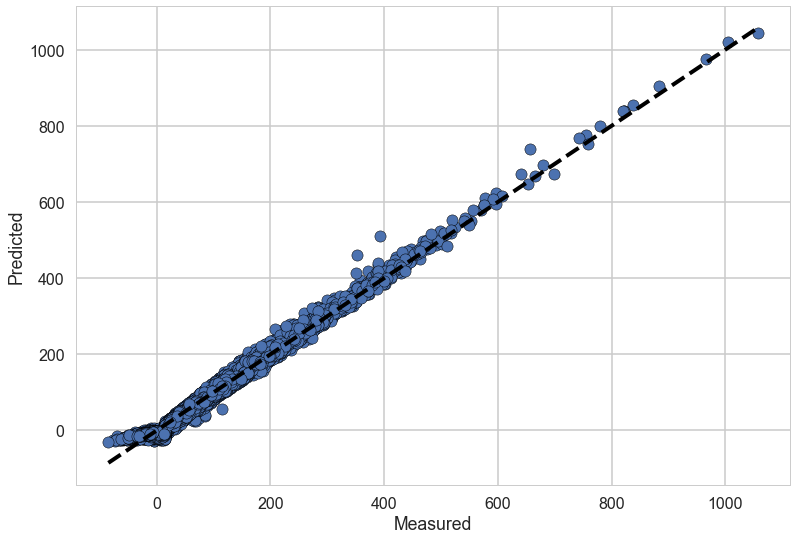

In [102]:
y=y_test
fig, ax = plt.subplots()
ax.scatter(y, y_pred, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

##### ElasticNet with tuned parameters seems to fit pretty well